In [1]:
# Load silver table
# Convert Pyspark dataframe to Pandas to use scikit-learn
df_silver = spark.read.table("silver")
df = df_silver.toPandas()

df.dtypes

StatementMeta(, 48435214-1cf6-4b7c-b7a7-0389e5c05286, 3, Finished, Available, Finished)

CustomerID                        object
ChurnLabel                        object
AccountLength                      int64
LocalCalls                         int64
LocalMins                        float64
IntlCalls                          int64
IntlMins                         float64
IntlActive                        object
IntlPlan                          object
ExtraInternationalCharges          int64
CustomerServiceCalls               int64
AvgMonthlyGBDownload               int64
UnlimitedDataPlan                 object
ExtraDataCharges                   int64
State                             object
PhoneNumber                       object
Gender                            object
Age                                int64
Under30                           object
Senior                            object
Group                             object
NumberofCustomersinGroup           int64
DeviceProtection&OnlineBackup     object
ContractType                      object
PaymentMethod   

In [3]:

import pandas as pd

# Define features (x) and target (y)
# x = all input variables for the ML model (need to select only relevant numeric and categorical variables)
# y = what we are trying to predict, if customer will churn or not --> Yes = 1, No = 0
selected_features = [
    'AccountLength',
    'LocalCalls',
    'LocalMins',
    'IntlCalls',
    'IntlMins',
    'IntlActive',
    'IntlPlan',
    'ExtraInternationalCharges',
    'CustomerServiceCalls',
    'AvgMonthlyGBDownload',
    'UnlimitedDataPlan',
    'ExtraDataCharges',
    'Under30',
    'Senior',
    'Age',
    'DeviceProtection&OnlineBackup',
    'ContractType',
    'PaymentMethod',
    'MonthlyCharge',
    'TotalCharges'
]

X = df[selected_features]
y = df['ChurnLabel'].map({'No': 0, 'Yes': 1}) # Target: binary classification

# Encode categorical vars
X_encoded = pd.get_dummies(X)

# Split into train/test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2)

# Train the model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict churn probability
df['ChurnProbability'] = model.predict_proba(X_encoded)[:,1]

# Categorize churn risk segment
df['ChurnRiskSegment'] = pd.cut(df['ChurnProbability'], bins=[0, 0.33, 0.66, 1.0], labels=["Low", "Medium", "High"])

# Save as Spark Table named "Customer_Churned_Scored"
df_scored = spark.createDataFrame(df[['CustomerID', 'ChurnProbability', 'ChurnRiskSegment']])
df_scored.write.mode("overwrite").saveAsTable("Customer_Churn_Scored")


StatementMeta(, 48435214-1cf6-4b7c-b7a7-0389e5c05286, 5, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [4]:
df_customer_churned_model = spark.read.table("Customer_Churn_Scored")

display(df_customer_churned_model)

StatementMeta(, 48435214-1cf6-4b7c-b7a7-0389e5c05286, 6, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, ce01db96-37e5-4dfd-8d17-38c400166d3b)

### Evaluate the model

Interpreting the Results:

Metric	Ideal Value	Notes
- Accuracy
    - Ideal Value: 0.70–0.90	
    - Higher is better, but watch for imbalance
- Precision	
    - Ideal Value: High = few false positives	
    - Good when churn communication is costly
- Recall
    -  Ideal Value: High = few missed churners	
    - Good when catching churn is most important
- F1
    -  Ideal Value:	Balance between precision and recall	
    - Ideal when false positives & negatives are both important
- AUC	
    -  Ideal Value: 0.7+ is decent, 0.8+ is good	
    - Measures how well the model ranks churn risk

StatementMeta(, 48435214-1cf6-4b7c-b7a7-0389e5c05286, 7, Finished, Available, Finished)

Accuracy:  0.81
Precision: 0.66
Recall:    0.57
F1 Score:  0.62
AUC-ROC:   0.84


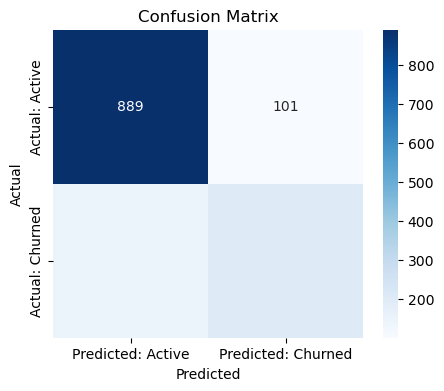

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]  # for AUC

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

# Print results
print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")
print(f"AUC-ROC:   {auc:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted: Active', 'Predicted: Churned'], yticklabels=['Actual: Active', 'Actual: Churned'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
